In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')

In [6]:
features_name = [i for i in train.columns.values if i not in ['connection_id', 'target']]

In [7]:
target = train['target']

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, train_size = 0.7, stratify = target, random_state = 2017)

# Model 1 - XGBoost with sklearn 0.78046
0.78046 this LB score is based on training on X_train data not on whole train data

In [8]:
clf1 = xgb.XGBClassifier()

In [10]:
clf1.fit(train[features_name], target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

<IPython.core.display.Javascript object>


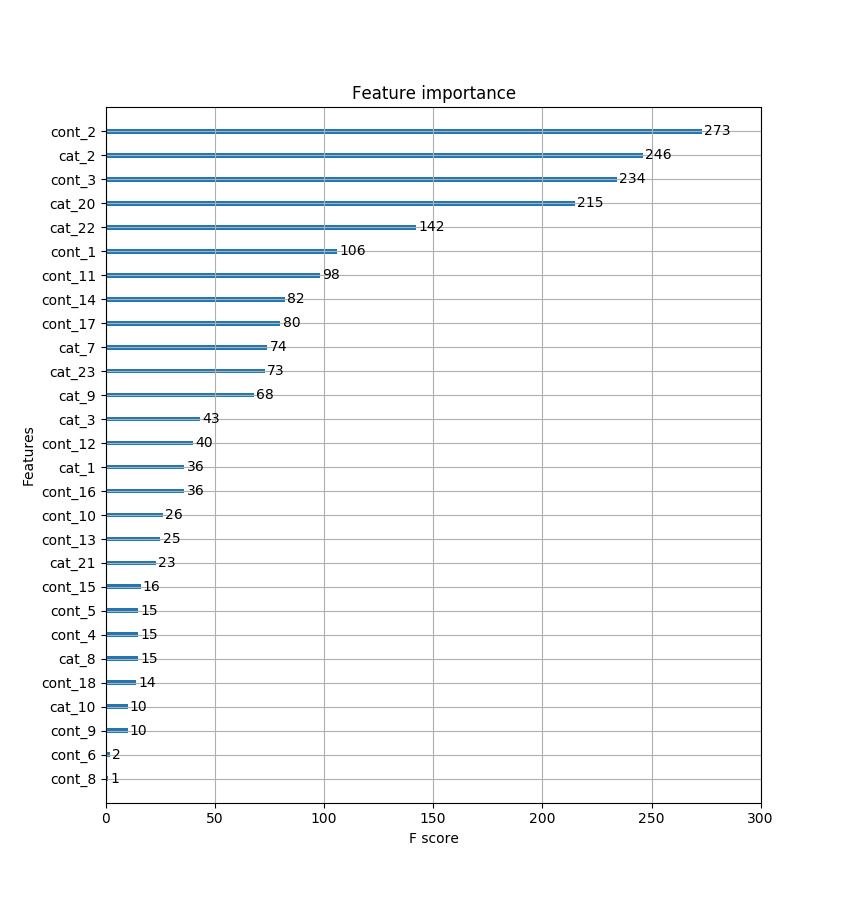

In [11]:
xgb.plot_importance(clf1)

In [14]:
# Fit model using each importance as a threshold
thresholds = np.sort(clf1.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf1, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train[features_name])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_valid[features_name])
    y_pred = selection_model.predict(select_X_test)
    # predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid, y_pred)
    print("Thresh=%.10f, n=%d, Accuracy: %.5f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0000000000, n=41, Accuracy: 78.03634%
Thresh=0.0004955402, n=28, Accuracy: 78.03634%
Thresh=0.0009910803, n=27, Accuracy: 78.03634%
Thresh=0.0049554012, n=26, Accuracy: 78.03437%
Thresh=0.0049554012, n=26, Accuracy: 78.03437%
Thresh=0.0069375620, n=24, Accuracy: 78.03241%
Thresh=0.0074331020, n=23, Accuracy: 78.03044%
Thresh=0.0074331020, n=23, Accuracy: 78.03044%
Thresh=0.0074331020, n=23, Accuracy: 78.03044%
Thresh=0.0079

###### here at Thresh = 0.0213082265 , n = 13 ,  Accuracy: 78.06391%  we get good accuracy so, at this thresh we should train our model
### Submodel 1 -  0.78051
###### here just by trainng entire data accuracy decreased 
<br>
if we have traind clf1 with X_train and have done feature selection process and after that training on X_train with selected features increase LB score to 0.78073
<br>###############################<br>
so i guess find important features of model for data X and in selectFromModel process train model on data X works best 

In [16]:
selection = SelectFromModel(clf1, threshold=0.0213082265, prefit=True)
select_X_train = selection.transform(train[features_name])
selection_model = xgb.XGBClassifier()
selection_model.fit(select_X_train, target)
select_X_test = selection.transform(test[features_name])
y_pred1 = selection_model.predict(select_X_test)

In [17]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb6.csv', index=False)

# Model  2 - XGBoost
### with number of trees and size tuning

In [19]:
# grid search
clf2 = xgb.XGBClassifier()

In [20]:
n_estimators = [50, 100, 150, 200, 250, 300]
max_depth = [1, 3, 5, 7, 9]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [22]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(clf2, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(train[features_name], target)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 169.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 409.6min finished


In [23]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473747 using {'max_depth': 3, 'n_estimators': 300}
-0.523281 (0.001389) with: {'max_depth': 1, 'n_estimators': 50}
-0.502667 (0.001716) with: {'max_depth': 1, 'n_estimators': 100}
-0.495161 (0.001581) with: {'max_depth': 1, 'n_estimators': 150}
-0.490659 (0.001358) with: {'max_depth': 1, 'n_estimators': 200}
-0.487612 (0.001230) with: {'max_depth': 1, 'n_estimators': 250}
-0.485531 (0.001166) with: {'max_depth': 1, 'n_estimators': 300}
-0.493305 (0.000927) with: {'max_depth': 3, 'n_estimators': 50}
-0.477281 (0.000938) with: {'max_depth': 3, 'n_estimators': 100}
-0.474970 (0.000948) with: {'max_depth': 3, 'n_estimators': 150}
-0.474214 (0.000926) with: {'max_depth': 3, 'n_estimators': 200}
-0.473909 (0.000925) with: {'max_depth': 3, 'n_estimators': 250}
-0.473747 (0.000949) with: {'max_depth': 3, 'n_estimators': 300}
-0.488361 (0.000769) with: {'max_depth': 5, 'n_estimators': 50}
-0.474972 (0.000901) with: {'max_depth': 5, 'n_estimators': 100}
-0.473921 (0.001019) with: {'max_

<IPython.core.display.Javascript object>


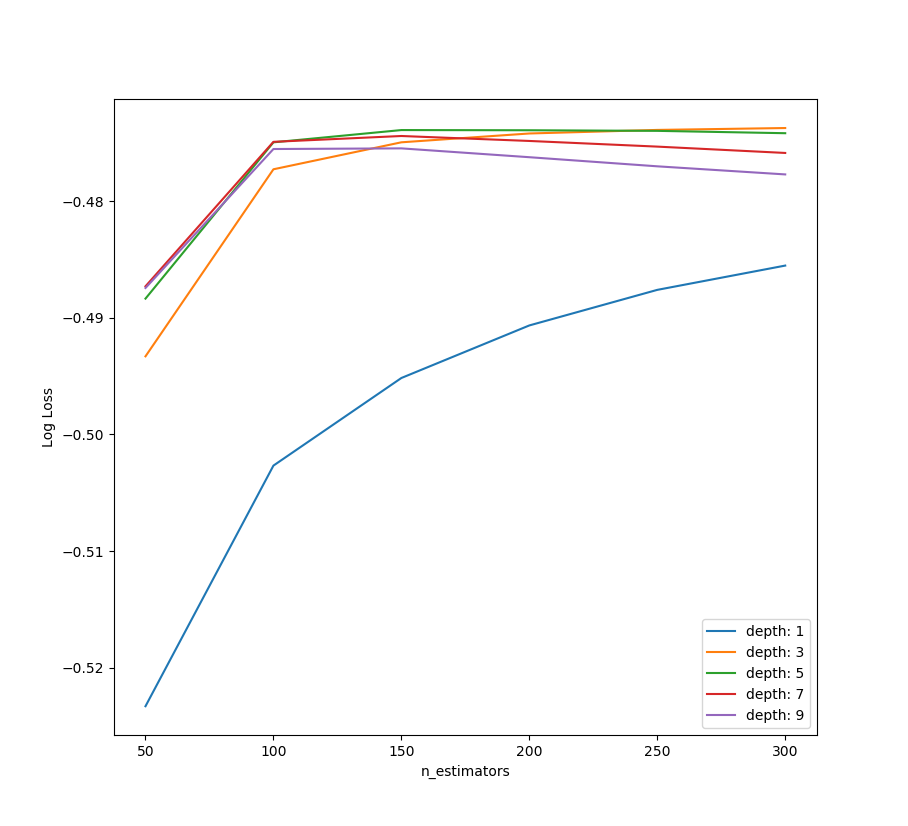

In [27]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
#pyplot.savefig('n_estimators_vs_max_depth.png')

In [32]:
n_estimators = [250, 300, 350, 400, 450, 500]
max_depth = [3, 4]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

In [33]:
kfold1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search1 = GridSearchCV(clf2, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold1, verbose=5)
grid_result1 = grid_search1.fit(train[features_name], target)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 114.9min finished


In [34]:
# summarize results
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473645 using {'max_depth': 4, 'n_estimators': 250}
-0.473971 (0.000583) with: {'max_depth': 3, 'n_estimators': 250}
-0.473830 (0.000599) with: {'max_depth': 3, 'n_estimators': 300}
-0.473751 (0.000588) with: {'max_depth': 3, 'n_estimators': 350}
-0.473725 (0.000593) with: {'max_depth': 3, 'n_estimators': 400}
-0.473744 (0.000611) with: {'max_depth': 3, 'n_estimators': 450}
-0.473807 (0.000603) with: {'max_depth': 3, 'n_estimators': 500}
-0.473645 (0.000593) with: {'max_depth': 4, 'n_estimators': 250}
-0.473680 (0.000579) with: {'max_depth': 4, 'n_estimators': 300}
-0.473779 (0.000581) with: {'max_depth': 4, 'n_estimators': 350}
-0.473895 (0.000596) with: {'max_depth': 4, 'n_estimators': 400}
-0.474021 (0.000595) with: {'max_depth': 4, 'n_estimators': 450}
-0.474149 (0.000590) with: {'max_depth': 4, 'n_estimators': 500}


<IPython.core.display.Javascript object>


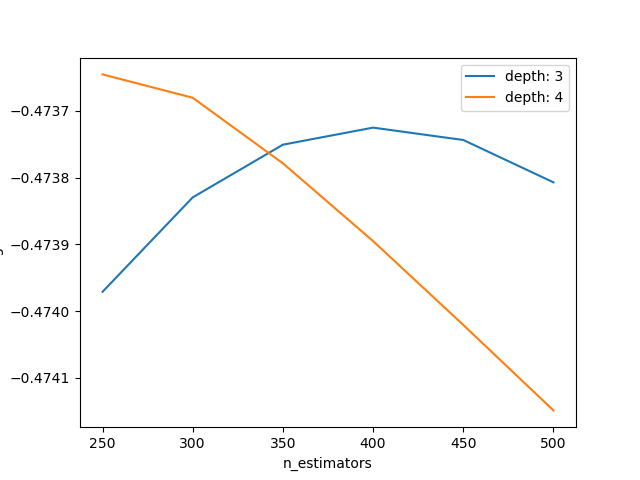

In [35]:
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

#### it seems that with n_estimators = 250 and max_depth = 4 we get higher accuracy

In [36]:
import pickle

In [37]:
filehandler = open("grid_result.pickle","wb")
pickle.dump(grid_result,filehandler)
filehandler.close()

In [38]:
filehandler = open("grid_result1.pickle","wb")
pickle.dump(grid_result1,filehandler)
filehandler.close()

### Model 3 - XGBoost  0.78128
##### train on all train data
##### lets make new classifier with n_estimators = 250 and max_depth = 4

In [40]:
clf3 = xgb.XGBClassifier(max_depth=4, n_estimators=250)

In [41]:
clf3.fit(train[features_name], target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [42]:
pred3 = clf3.predict(test[features_name])

In [43]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred3
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb7.csv', index=False)

## Model 4 -XGBoost  0.78103
##### train on X_train data 

In [44]:
clf4 = xgb.XGBClassifier(max_depth=4, n_estimators=250)

In [45]:
clf4.fit(X_train[features_name], y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [46]:
pred_valid4 = clf4.predict(X_valid[features_name])

In [48]:
accuracy_valid4 = accuracy_score(y_valid, pred_valid4)
print("Accuracy for validation data : %.5f%%" % (accuracy_valid4 * 100.0))

Accuracy for validation data : 78.10525%


In [49]:
pred_train4 = clf4.predict(X_train[features_name])

In [50]:
accuracy_train4 = accuracy_score(y_train, pred_train4)
print("Accuracy for X_train : %.5f%%" % (accuracy_train4 * 100.0))

Accuracy for X_train : 78.21186%


In [51]:
#predict for test data and see LB score
pred4 = clf4.predict(test[features_name])

In [52]:
## make submission 
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred4
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb8.csv', index=False)

#### this got lower LB score than last one where we have trained the model on entire train data

### let's  find feature importance for model 4 and find best feature using selectFromModel  0.78125
##### we got better result for model 4 with important features

<IPython.core.display.Javascript object>


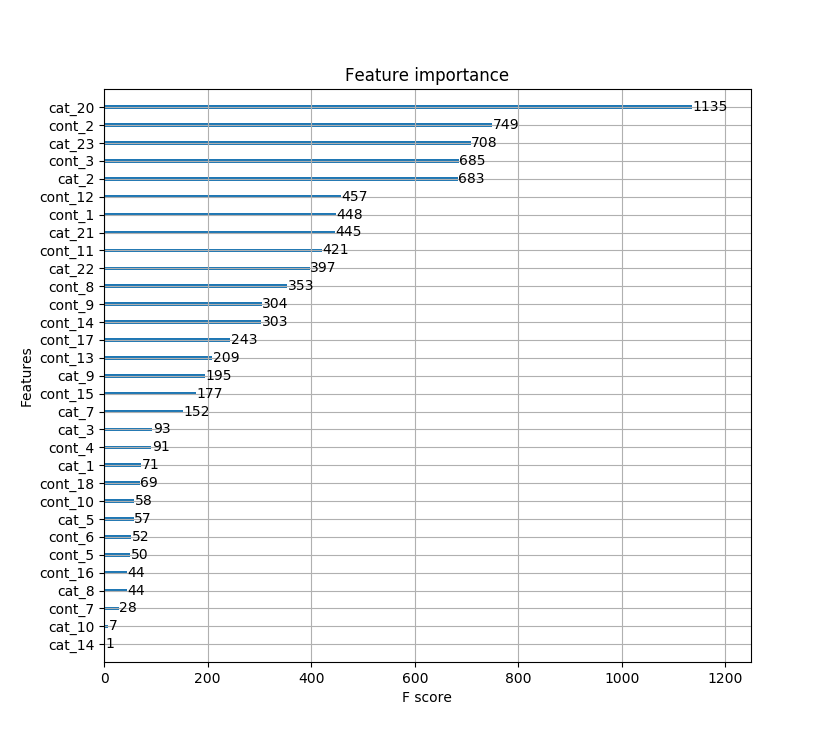

In [53]:
xgb.plot_importance(clf4)

In [54]:
# Fit model using each importance as a threshold
thresholds = np.sort(clf4.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf4, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train[features_name])
    # train model
    selection_model = xgb.XGBClassifier(max_depth=4, n_estimators=250)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_valid[features_name])
    y_pred = selection_model.predict(select_X_test)
    # predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid, y_pred)
    print("Thresh=%.10f, n=%d, Accuracy: %.5f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0001145607, n=31, Accuracy: 78.10525%
Thresh=0.0008019246, n=30, Accuracy: 78.09147%
Thresh=0.0032076985, n=29, Accuracy: 78.08359%
Thresh=0.0050406689, n=28, Accuracy: 78.10131%
Thresh=0.0050406689, n=28, Accuracy: 78.10131%
Thresh=0.0057280329, n=26, Accuracy: 78.10328%
Thresh=0.0059571541, n=25, Accuracy: 78.09738%
Thresh=0.0065299575, n=24, Accuracy: 78.08950%
Thresh=0.0066445181, n=23, Accuracy: 78.09344%
Thresh=0.0079046851, n=22, Accuracy: 78.09738%
Thresh=0.0081338072, n=21, Accuracy: 78.09344%
Thresh=0.0104

#### wow nothing improved, for n=41  , Thresh=0.0000000000 and n= 15 , Thresh=0.0239431784  we get maximum CV score for model 4

In [55]:
selection = SelectFromModel(clf4, threshold=0.0239431784, prefit=True)
select_X_train = selection.transform(train[features_name])
selection_model = xgb.XGBClassifier(max_depth=4, n_estimators=250)
selection_model.fit(select_X_train, target)
select_X_test = selection.transform(test[features_name])
y_pred1 = selection_model.predict(select_X_test)

In [56]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb9.csv', index=False)

#### this is better result than model 4 with all features , so it seems like score increses if we use important features

### let's  find feature importance for model 3 and find best feature using selectFromModel  0.78120
###### model 3 is trained on entire train data and has maximum score 
##### we got less LB score than model 3 which is trained with all the features

<IPython.core.display.Javascript object>


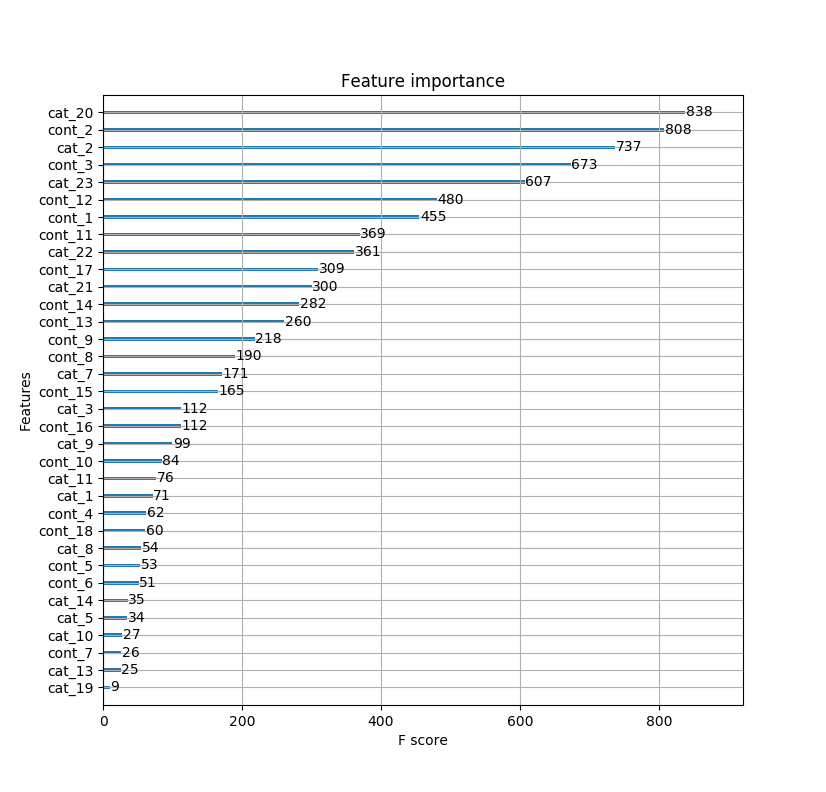

In [57]:
xgb.plot_importance(clf3)

In [58]:
# Fit model using each importance as a threshold
thresholds = np.sort(clf3.feature_importances_)
for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(clf3, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train[features_name])
        # train model
        selection_model = xgb.XGBClassifier(max_depth=4, n_estimators=250)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_valid[features_name])
        y_pred = selection_model.predict(select_X_test)
        # predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_valid, y_pred)
        print("Thresh=%.10f, n=%d, Accuracy: %.5f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0000000000, n=41, Accuracy: 78.10525%
Thresh=0.0010958237, n=34, Accuracy: 78.10525%
Thresh=0.0030439547, n=33, Accuracy: 78.10525%
Thresh=0.0031657128, n=32, Accuracy: 78.10525%
Thresh=0.0032874711, n=31, Accuracy: 78.09738%
Thresh=0.0041397782, n=30, Accuracy: 78.09738%
Thresh=0.0042615365, n=29, Accuracy: 78.10328%
Thresh=0.0062096678, n=28, Accuracy: 78.09147%
Thresh=0.0064531839, n=27, Accuracy: 78.10525%
Thresh=0.0065749423, n=26, Accuracy: 78.11116%
Thresh=0.0073054913, n=25, Accuracy: 78.09541%
Thresh=0.0075490079, n=24, Accuracy: 78.10328%
Thresh=0.0086448314, n=23, Accuracy: 78.10722%
Thresh=0.0092536220, n=22, Accuracy: 78.09934%
Thresh=0.0102276877, n=21, Accuracy: 78.09934%
Thresh=0.0120

#### Thresh=0.0065749423, n=26, Accuracy: 78.11116% has higest accuracy for model 3

In [59]:
selection = SelectFromModel(clf3, threshold=0.0065749423, prefit=True)
select_X_train = selection.transform(train[features_name])
selection_model = xgb.XGBClassifier(max_depth=4, n_estimators=250)
selection_model.fit(select_X_train, target)
select_X_test = selection.transform(test[features_name])
y_pred1 = selection_model.predict(select_X_test)

In [60]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb10.csv', index=False)

## Model 5 - XGBoost with other parameter tuning

In [61]:
clf5 = xgb.XGBClassifier(max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.8)

In [62]:
min_child_weight = [1, 3, 5, 7]
param_grid = dict(min_child_weight=min_child_weight)

In [64]:
kfold5 = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search5 = GridSearchCV(clf5, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold5, verbose=2)
grid_result5 = grid_search5.fit(train[features_name], target)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 12.6min finished


In [65]:
# summarize results
print("Best: %f using %s" % (grid_result5.best_score_, grid_result5.best_params_))
means = grid_result5.cv_results_['mean_test_score']
stds = grid_result5.cv_results_['std_test_score']
params = grid_result5.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473831 using {'min_child_weight': 1}
-0.473831 (0.000177) with: {'min_child_weight': 1}
-0.473883 (0.000211) with: {'min_child_weight': 3}
-0.473901 (0.000220) with: {'min_child_weight': 5}
-0.473943 (0.000212) with: {'min_child_weight': 7}


In [69]:
min_child_weight = [1, 2]
param_grid = dict(min_child_weight=min_child_weight)

In [70]:
kfold5 = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search5 = GridSearchCV(clf5, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold5, verbose=2)
grid_result5 = grid_search5.fit(train[features_name], target)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  4.4min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.6min finished


In [71]:
# summarize results
print("Best: %f using %s" % (grid_result5.best_score_, grid_result5.best_params_))
means = grid_result5.cv_results_['mean_test_score']
stds = grid_result5.cv_results_['std_test_score']
params = grid_result5.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473831 using {'min_child_weight': 1}
-0.473831 (0.000177) with: {'min_child_weight': 1}
-0.473847 (0.000188) with: {'min_child_weight': 2}


#### min_child_weight= 1 is best with max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.8
here min_child_weight is 1 by default so no need to change that

In [72]:
gamma = [i/10.0 for i in range(0,5)]
param_grid = dict(gamma=gamma)

In [73]:
kfold6 = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search6 = GridSearchCV(clf5, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result6 = grid_search6.fit(train[features_name], target)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 16.1min finished


In [74]:
# summarize results
print("Best: %f using %s" % (grid_result6.best_score_, grid_result6.best_params_))
means = grid_result6.cv_results_['mean_test_score']
stds = grid_result6.cv_results_['std_test_score']
params = grid_result6.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473831 using {'gamma': 0.0}
-0.473831 (0.000177) with: {'gamma': 0.0}
-0.473868 (0.000211) with: {'gamma': 0.1}
-0.473845 (0.000212) with: {'gamma': 0.2}
-0.473833 (0.000230) with: {'gamma': 0.3}
-0.473842 (0.000212) with: {'gamma': 0.4}


#### gamma = 0 is best with  min_child_weight= 1, max_depth=4,  n_estimators=250, subsample=0.8, colsample_bytree=0.8

In [75]:
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_grid = dict(gamma=gamma, colsample_bytree=colsample_bytree)

In [76]:
grid_search7 = GridSearchCV(clf5, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result7 = grid_search7.fit(train[features_name], target)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 60.6min finished


In [77]:
# summarize results
print("Best: %f using %s" % (grid_result7.best_score_, grid_result7.best_params_))
means = grid_result7.cv_results_['mean_test_score']
stds = grid_result7.cv_results_['std_test_score']
params = grid_result7.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473683 using {'gamma': 0.1, 'colsample_bytree': 0.6}
-0.473701 (0.000224) with: {'gamma': 0.0, 'colsample_bytree': 0.6}
-0.473683 (0.000240) with: {'gamma': 0.1, 'colsample_bytree': 0.6}
-0.473701 (0.000247) with: {'gamma': 0.2, 'colsample_bytree': 0.6}
-0.473731 (0.000229) with: {'gamma': 0.3, 'colsample_bytree': 0.6}
-0.473704 (0.000244) with: {'gamma': 0.4, 'colsample_bytree': 0.6}
-0.473729 (0.000207) with: {'gamma': 0.0, 'colsample_bytree': 0.7}
-0.473778 (0.000178) with: {'gamma': 0.1, 'colsample_bytree': 0.7}
-0.473751 (0.000220) with: {'gamma': 0.2, 'colsample_bytree': 0.7}
-0.473754 (0.000231) with: {'gamma': 0.3, 'colsample_bytree': 0.7}
-0.473767 (0.000207) with: {'gamma': 0.4, 'colsample_bytree': 0.7}
-0.473831 (0.000177) with: {'gamma': 0.0, 'colsample_bytree': 0.8}
-0.473868 (0.000211) with: {'gamma': 0.1, 'colsample_bytree': 0.8}
-0.473845 (0.000212) with: {'gamma': 0.2, 'colsample_bytree': 0.8}
-0.473833 (0.000230) with: {'gamma': 0.3, 'colsample_bytree': 0.8}


#### gamma = 0.1 and colsample_bytree = 0.6 works best with max_depth=4, n_estimators=250, subsample=0.8,min_child_weight= 1

### Model 6 - XGB model with tuned parameters  0.78131

In [78]:
clf6 = xgb.XGBClassifier(max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1,min_child_weight= 1)

In [79]:
clf6.fit(train[features_name], target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [80]:
pred6 = clf6.predict(test[features_name])

In [81]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred6
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb11.csv', index=False)

##### ################################

In [82]:
param_grid = dict(subsample=subsample)
grid_search8 = GridSearchCV(clf6, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result8 = grid_search8.fit(train[features_name], target)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 10.9min finished


In [83]:
# summarize results
print("Best: %f using %s" % (grid_result8.best_score_, grid_result8.best_params_))
means = grid_result8.cv_results_['mean_test_score']
stds = grid_result8.cv_results_['std_test_score']
params = grid_result8.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473683 using {'subsample': 0.8}
-0.473815 (0.000264) with: {'subsample': 0.6}
-0.473780 (0.000276) with: {'subsample': 0.7}
-0.473683 (0.000240) with: {'subsample': 0.8}
-0.473703 (0.000268) with: {'subsample': 0.9}


In [84]:
subsample = [0.75, 0.80, 0.85]
param_grid = dict(subsample=subsample)
grid_search8 = GridSearchCV(clf6, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result8 = grid_search8.fit(train[features_name], target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  7.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.1min finished


In [85]:
# summarize results
print("Best: %f using %s" % (grid_result8.best_score_, grid_result8.best_params_))
means = grid_result8.cv_results_['mean_test_score']
stds = grid_result8.cv_results_['std_test_score']
params = grid_result8.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473683 using {'subsample': 0.8}
-0.473765 (0.000234) with: {'subsample': 0.75}
-0.473683 (0.000240) with: {'subsample': 0.8}
-0.473694 (0.000253) with: {'subsample': 0.85}


####  max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1,min_child_weight= 1

In [87]:
reg_alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 1, 5]
param_grid = dict(reg_alpha=reg_alpha)
grid_search9 = GridSearchCV(clf6, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result9 = grid_search9.fit(train[features_name], target)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.6min finished


In [88]:
# summarize results
print("Best: %f using %s" % (grid_result9.best_score_, grid_result9.best_params_))
means = grid_result9.cv_results_['mean_test_score']
stds = grid_result9.cv_results_['std_test_score']
params = grid_result9.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473678 using {'reg_alpha': 0.001}
-0.473683 (0.000240) with: {'reg_alpha': 0}
-0.473678 (0.000254) with: {'reg_alpha': 0.001}
-0.473679 (0.000233) with: {'reg_alpha': 0.005}
-0.473681 (0.000228) with: {'reg_alpha': 0.01}
-0.473717 (0.000292) with: {'reg_alpha': 0.05}
-0.473736 (0.000256) with: {'reg_alpha': 0.1}
-0.473702 (0.000256) with: {'reg_alpha': 0.15}
-0.473703 (0.000232) with: {'reg_alpha': 0.2}
-0.473772 (0.000283) with: {'reg_alpha': 1}
-0.474108 (0.000316) with: {'reg_alpha': 5}


In [89]:
reg_alpha = [0.0005, 0.001, 0.0015]
param_grid = dict(reg_alpha=reg_alpha)
grid_search9 = GridSearchCV(clf6, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result9 = grid_search9.fit(train[features_name], target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  7.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.6min finished


In [90]:
# summarize results
print("Best: %f using %s" % (grid_result9.best_score_, grid_result9.best_params_))
means = grid_result9.cv_results_['mean_test_score']
stds = grid_result9.cv_results_['std_test_score']
params = grid_result9.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473678 using {'reg_alpha': 0.001}
-0.473678 (0.000242) with: {'reg_alpha': 0.0005}
-0.473678 (0.000254) with: {'reg_alpha': 0.001}
-0.473697 (0.000263) with: {'reg_alpha': 0.0015}


#### max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1,min_child_weight= 1, reg_alpha=0.001 

## Model 7 - XGB   0.78136
max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha = 0.001

In [3]:
clf7 = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [9]:
clf7.fit(train[features_name], target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [93]:
pred7 = clf7.predict(test[features_name])

In [94]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred7
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb12.csv', index=False)

## Model 8 XGB  0.78018
max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha = 0.001, learning_rate=0.01

In [95]:
clf8 = xgb.XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)

In [96]:
clf8.fit(train[features_name], target)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='multi:softprob', reg_alpha=0.001, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [97]:
pred8 = clf8.predict(test[features_name])

In [98]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = pred8
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb13.csv', index=False)

In [99]:
learning_rate = [0.001, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
param_grid = dict(learning_rate=learning_rate)
grid_search10 = GridSearchCV(clf7, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result10 = grid_search10.fit(train[features_name], target)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 19.1min finished


In [100]:
# summarize results
print("Best: %f using %s" % (grid_result10.best_score_, grid_result10.best_params_))
means = grid_result10.cv_results_['mean_test_score']
stds = grid_result10.cv_results_['std_test_score']
params = grid_result10.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473678 using {'learning_rate': 0.1}
-0.942310 (0.000068) with: {'learning_rate': 0.001}
-0.474246 (0.000211) with: {'learning_rate': 0.05}
-0.473678 (0.000254) with: {'learning_rate': 0.1}
-0.474060 (0.000280) with: {'learning_rate': 0.15}
-0.474672 (0.000174) with: {'learning_rate': 0.2}
-0.475387 (0.000390) with: {'learning_rate': 0.25}
-0.475994 (0.000375) with: {'learning_rate': 0.3}


In [101]:
learning_rate = [0.75, 0.1, 0.125]
param_grid = dict(learning_rate=learning_rate)
grid_search10 = GridSearchCV(clf7, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold6, verbose=2)
grid_result10 = grid_search10.fit(train[features_name], target)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  7.1min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  8.2min finished


In [102]:
# summarize results
print("Best: %f using %s" % (grid_result10.best_score_, grid_result10.best_params_))
means = grid_result10.cv_results_['mean_test_score']
stds = grid_result10.cv_results_['std_test_score']
params = grid_result10.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.473678 using {'learning_rate': 0.1}
-0.481902 (0.000597) with: {'learning_rate': 0.75}
-0.473678 (0.000254) with: {'learning_rate': 0.1}
-0.473906 (0.000283) with: {'learning_rate': 0.125}


### max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha = 0.001, learning_rate=0.1
this is the best we got so far

<IPython.core.display.Javascript object>


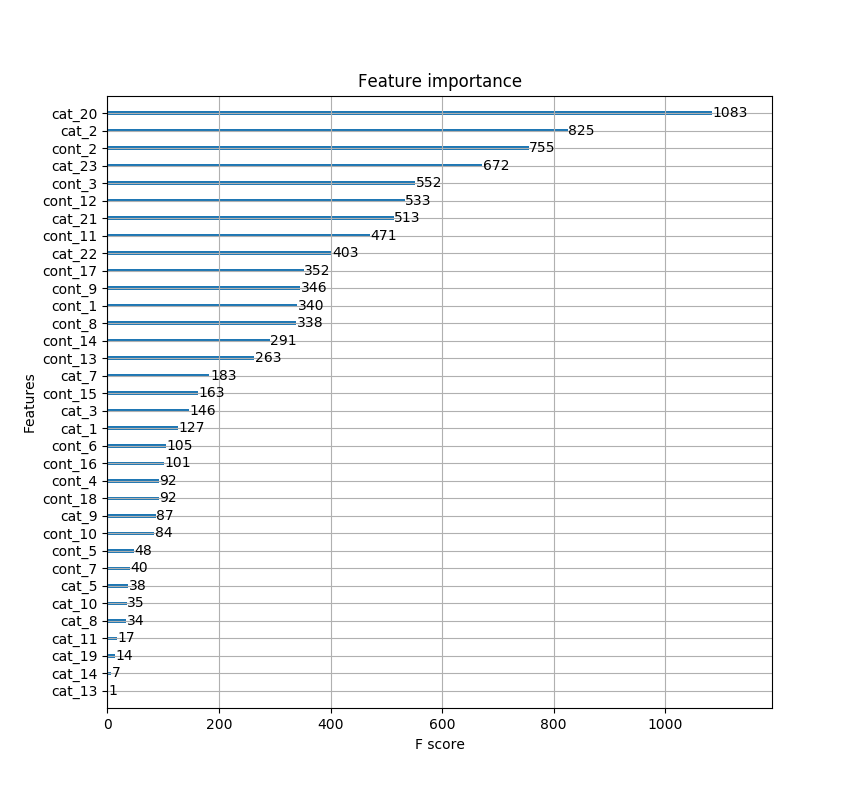

In [103]:
xgb.plot_importance(clf7)

In [ ]:
# Fit model using each importance as a threshold
thresholds = np.sort(clf7.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf7, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train[features_name])
    # train model
    selection_model = xgb.XGBClassifier(max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha = 0.001, learning_rate=0.1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_valid[features_name])
    y_pred = selection_model.predict(select_X_test)
    # predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_valid, y_pred)
    print("Thresh=%.10f, n=%d, Accuracy: %.5f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0000000000, n=41, Accuracy: 78.10131%
Thresh=0.0001092777, n=34, Accuracy: 78.10525%
Thresh=0.0007649437, n=33, Accuracy: 78.10525%
Thresh=0.0015298874, n=32, Accuracy: 78.10131%
Thresh=0.0018577204, n=31, Accuracy: 78.11116%
Thresh=0.0037154409, n=30, Accuracy: 78.10919%
Thresh=0.0038247185, n=29, Accuracy: 78.09738%
Thresh=0.0041525518, n=28, Accuracy: 78.10131%
Thresh=0.0043711071, n=27, Accuracy: 78.10131%
Thresh=0.0052453284, n=26, Accuracy: 78.11313%
Thresh=0.0091793248, n=25, Accuracy: 78.10919%
Thresh=0.0095071578, n=24, Accuracy: 78.10131%
Thresh=0.0100535462, n=23, Accuracy: 78.11116%
Thresh=0.0100535462, n=23, Accuracy: 78.11116%
Thresh=0.0110370452, n=21, Accuracy: 78.10919%
Thresh=0.0114

#### use threhold = 0.0052453284 , LB score 0.78112

In [10]:
selection = SelectFromModel(clf7, threshold=0.0052453284, prefit=True)
select_X_train = selection.transform(train[features_name])
selection_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)
selection_model.fit(select_X_train, target)
select_X_test = selection.transform(test[features_name])
y_pred1 = selection_model.predict(select_X_test)

In [11]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb14.csv', index=False)

#### 0.78120

In [12]:
selection = SelectFromModel(clf7, threshold=0.0317998044, prefit=True)
select_X_train = selection.transform(train[features_name])
selection_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=250, subsample=0.8, colsample_bytree=0.6, gamma=0.1, min_child_weight= 1, reg_alpha=0.001)
selection_model.fit(select_X_train, target)
select_X_test = selection.transform(test[features_name])
y_pred1 = selection_model.predict(select_X_test)

In [13]:
## make submission
sub = pd.read_csv('sample_submission.csv')
sub['target'] = y_pred1
sub['target'] = sub['target'].astype(int)
sub.to_csv('sub_xgb15.csv', index=False)